In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
GREEN = (0, 255, 0)

In [6]:
def image_to_array(image) :
    image_array = np.asarray(image)
    return np.array([[(val, val, val) for val in row] for row in image_array])

In [7]:
SCRIPT_PATH = os.getcwd()
IMAGE_DIRECTORY = os.path.join(SCRIPT_PATH, 'images')

In [8]:
def invert(image, pattern, mode = "ceasar") :

    # Odwrócenie kolorów (czarne tło)
    inverted_image = deepcopy(image)
    inverted_pattern = deepcopy(pattern)

    if mode == "ceasar" :
        inverted_image = cv2.bitwise_not(inverted_image)
        inverted_pattern = cv2.bitwise_not(inverted_pattern)
        
    return inverted_image, inverted_pattern

In [9]:

def load_image(mode = "ceasar") :
    image_name = None
    pattern_name = None

    if mode == "ceasar" :
        image_name = "galia.png"
        pattern_name = "galia_e.png"
    elif mode == "fish" :
        image_name = "school.jpg"
        pattern_name = "fish1.png"
    else :
        raise Exception("Non existing mode")
    
    
    # Podaj bezpośrednią ścieżkę do pliku
    IMAGE_PATH = os.path.join(IMAGE_DIRECTORY, image_name)
    PATTERN_PATH = os.path.join(IMAGE_DIRECTORY, pattern_name)
    
    # Wczytanie obrazu
    image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
    pattern = cv2.imread(PATTERN_PATH, cv2.IMREAD_GRAYSCALE)
    
    return image, pattern

In [10]:
# podaj image
DFT = lambda x : cv2.dft(np.float32(x), flags=cv2.DFT_COMPLEX_OUTPUT)
# podaj dft
DFT_shift = lambda x : np.fft.fftshift(x)
# podaj dft_shift
MAGNITUDE_spectrum = lambda x : 20 * np.log(cv2.magnitude(x[:, :, 0], x[:, :, 1]))
PHASE_spectrum = lambda x : np.angle(x)
# podaj phase_spectrum, chosen_phase
PHASE_display = lambda x, y : x[:,:,y]

In [11]:
def plot_image(image, title, colormap = "gray") :
    plt.figure(figsize=(20, 20))
    plt.plot()
    plt.imshow(image, cmap = colormap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [12]:
def show_pattern(image, correlation, probability, mark, thickness = 10, color = GREEN) :
    print(image.shape)
    w, h, _ = image.shape
    
    a,b = max(mark), min(mark)
    c = np.sqrt(a**2-b**2)
    d = np.sqrt(b**2 + c**2)
    a_2,b_2 = a + thickness, b + thickness
    c_2 = np.sqrt(a_2**2-b_2**2)
    d_2 = np.sqrt(b_2**2 + c_2**2)
    
    appearances = []
    width, height = correlation.shape
    for x in range(width) :
        for y in range(height) :
            if correlation[x, y] > probability :
                appearances.append((x - b//2,y - a//2))
    
    
    def distance(point_a, point_b) :
        return np.sqrt( ( (point_a[0] - point_b[0])**2 ) + ( (point_a[1] - point_b[1])**2 ) )
    
    def is_good(point, centerpoint) :
        nonlocal a, b, c, d, a_2, b_2, c_2, d_2
        
        
        if distance(point, centerpoint) < min(a, b, a_2, b_2) or distance(point, centerpoint) > max(a, b, a_2, b_2) : return False
        
        o_x, o_y = centerpoint
        A = o_x, o_y + c
        B = o_x, o_y - c
        
        
        A_2 = o_x, o_y + c_2
        B_2 = o_x, o_y - c_2
        d_a = distance(point, A)
        d_b = distance(point, B)
        d_2a = distance(point, A_2)
        d_2b = distance(point, B_2)
        
        if d_a + d_b >= 2*min(d, d_2) :
            if d_2a + d_2b <= 2*max(d, d_2) :
                return True
        return False
        
    new_image = deepcopy(image)
    
    k = 1
    for x, y in appearances :
        centerpoint = (x,y)
        k += 1
        for i in range(max(0, x - b_2), min(h, x + b_2)) :
            for j in range(max(0, y - a_2), min(w, y + a_2)) :
                if is_good((i,j), centerpoint) :
                    new_image[i,j] = color
    
    
    plot_image(new_image, 'Image with detected pattern appearances')

In [13]:
def find_corelation(image, pattern) :
    h, w = image.shape

    correlation = np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(np.rot90(np.rot90(pattern)), s = (h, w))).real
    correlation /= np.abs(np.max(correlation))
    return correlation


In [14]:
mode = "fish"
chosen_phase = 1

In [15]:
image, pattern = load_image(mode)

In [16]:
inverted_image, inverted_pattern = invert(image, pattern, mode)

[[ 86  87  87 ... 107 107 107]
 [ 87  87  88 ... 107 106 107]
 [ 85  85  85 ... 107 107 107]
 ...
 [ 25  25  25 ...  20  19  19]
 [ 26  26  26 ...  20  19  19]
 [ 25  26  26 ...  20  19  19]]


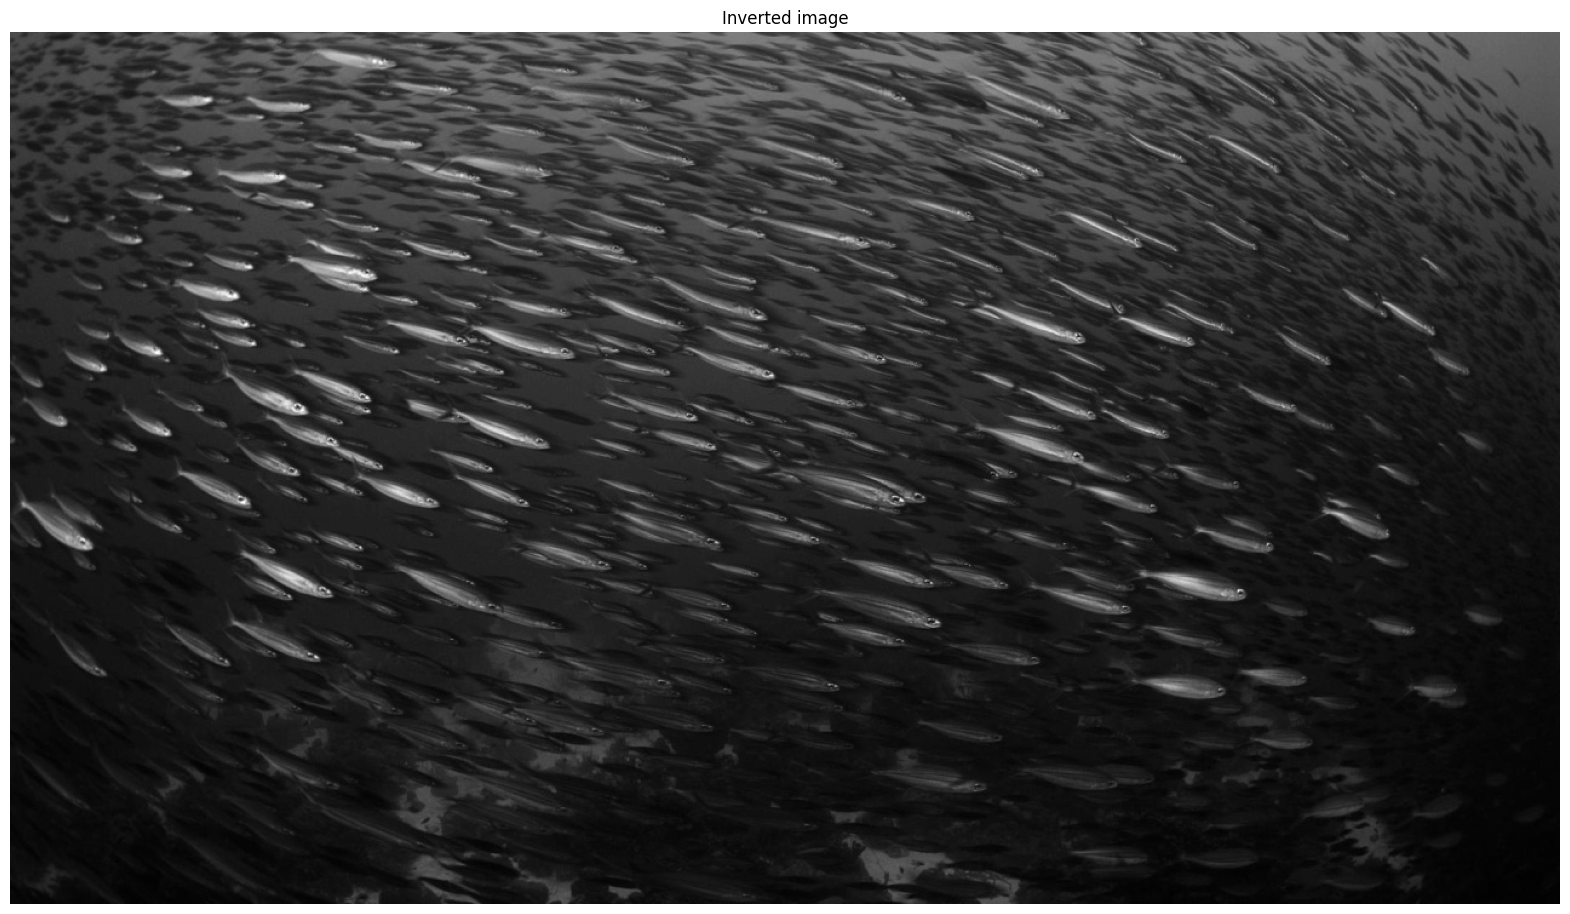

In [17]:
plot_image(inverted_image, "Inverted image")


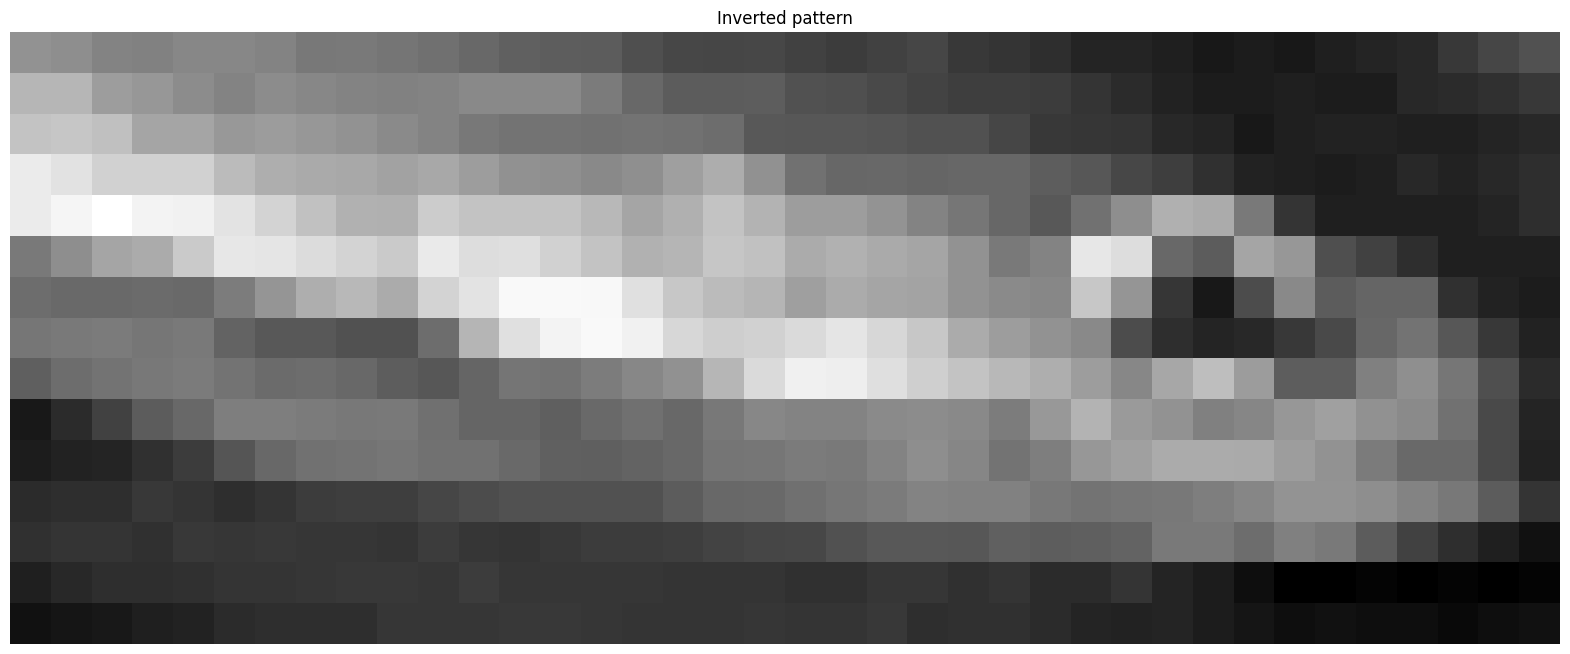

In [18]:
plot_image(inverted_pattern, "Inverted pattern")


In [19]:

dft = DFT(inverted_image)


In [20]:
# plot_image(dft, "DFT of inverted image")
dft_shift = DFT_shift(dft)


In [21]:
magnitude_spectrum = MAGNITUDE_spectrum(dft_shift)


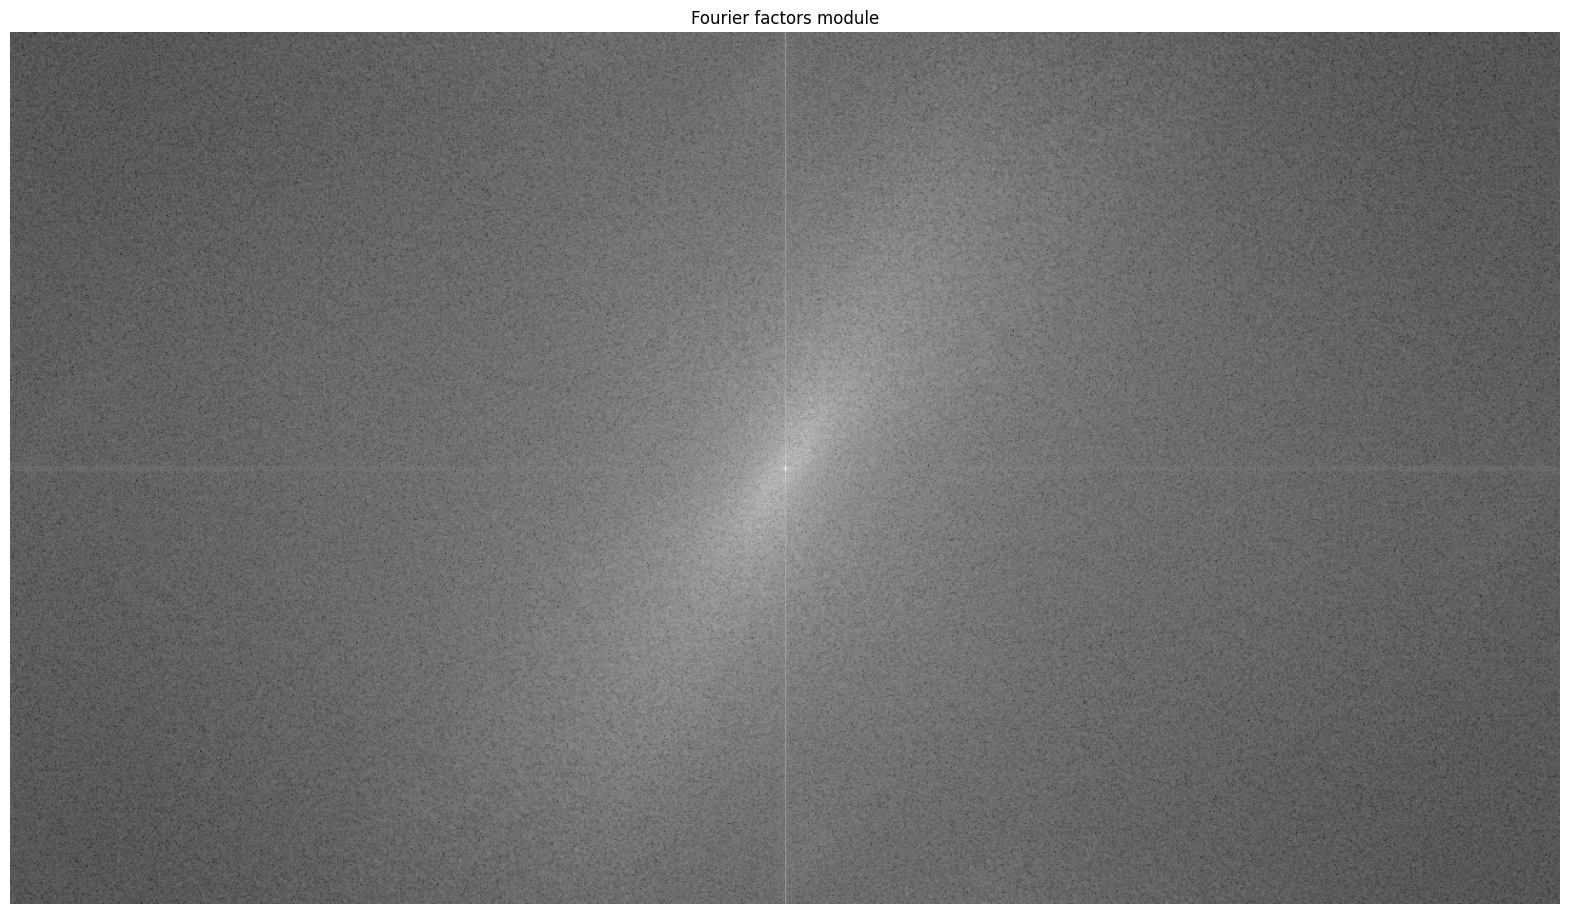

In [22]:
plot_image(magnitude_spectrum, "Fourier factors module")


In [23]:
phase_spectrum = PHASE_spectrum(dft_shift)


In [24]:
phase_to_display = PHASE_display(phase_spectrum, chosen_phase)

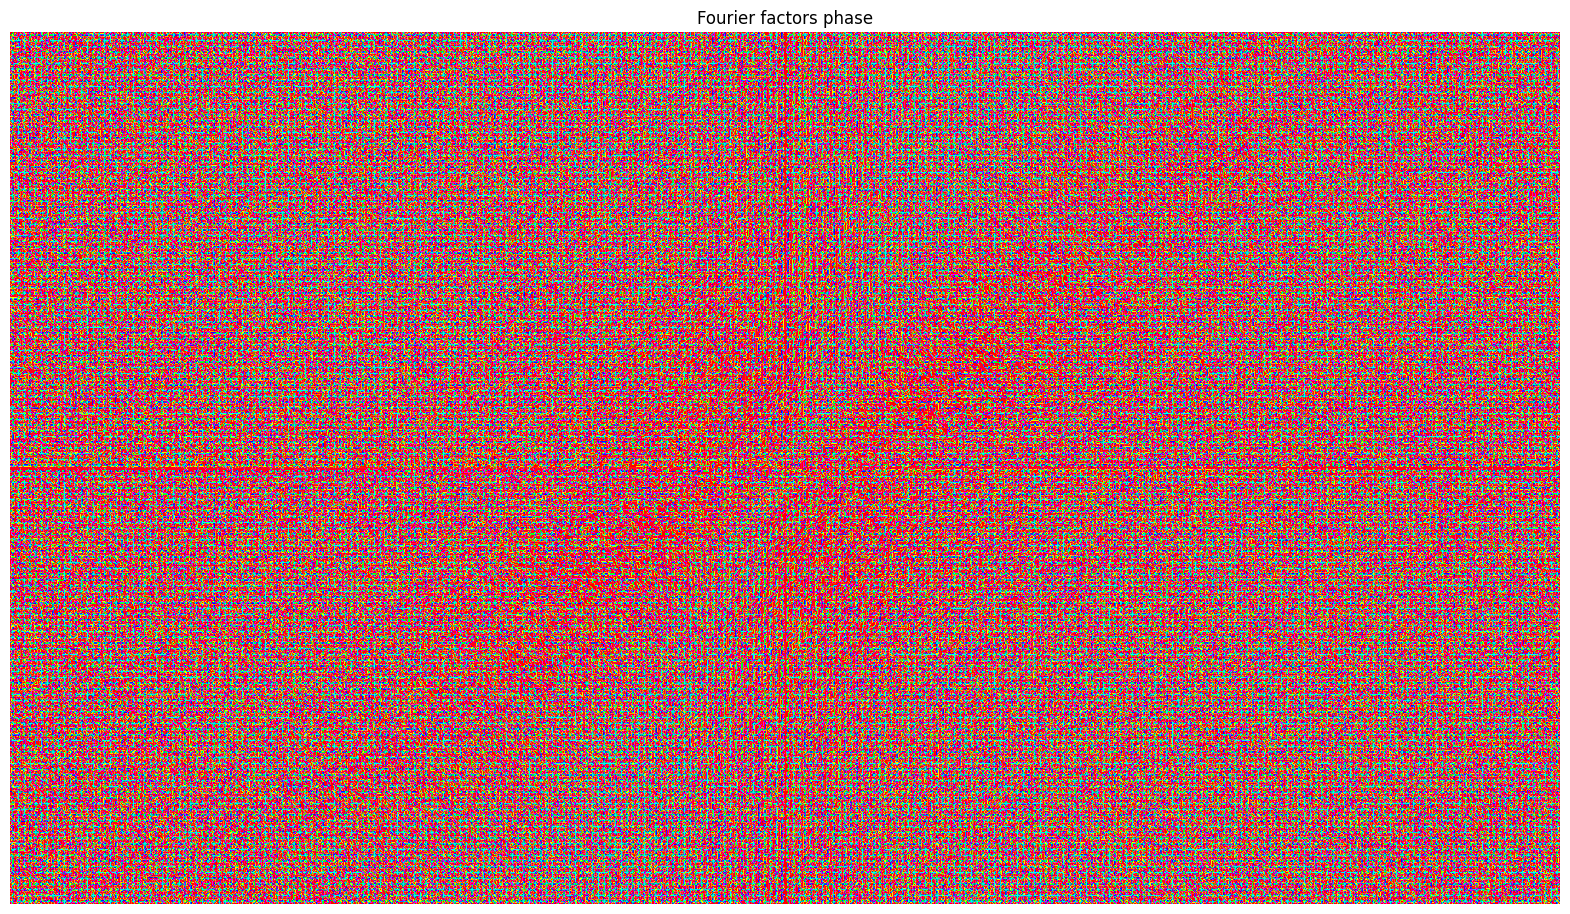

In [25]:

plot_image(phase_to_display, "Fourier factors phase", "hsv")

In [26]:

correlation = find_corelation(inverted_image, inverted_pattern)

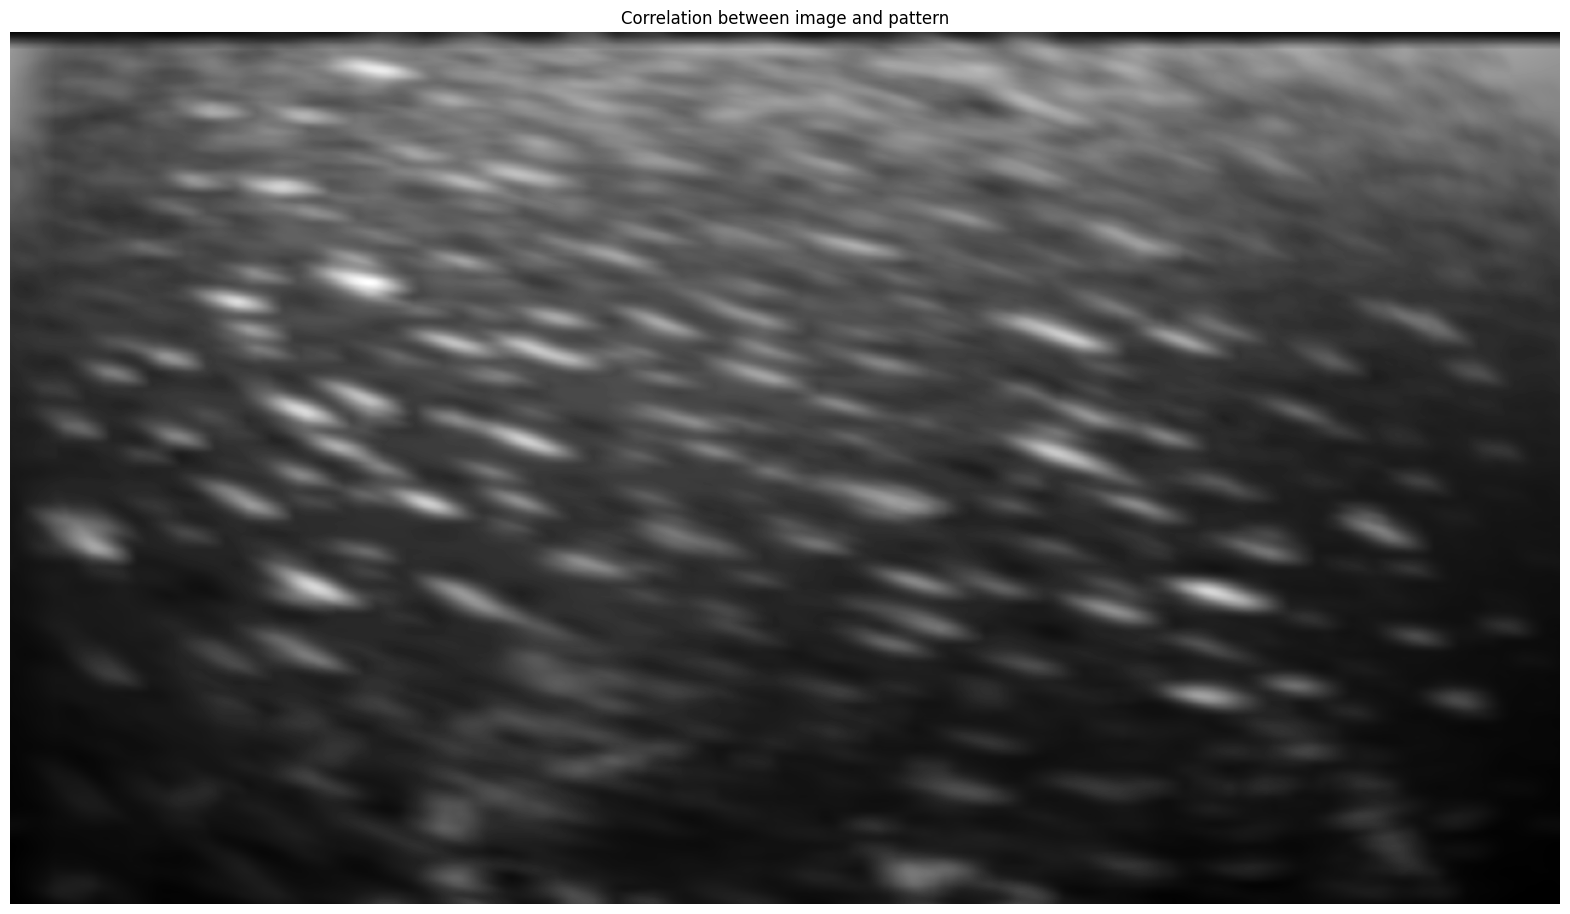

In [27]:

plot_image(correlation, "Correlation between image and pattern")

(720, 1280, 3)


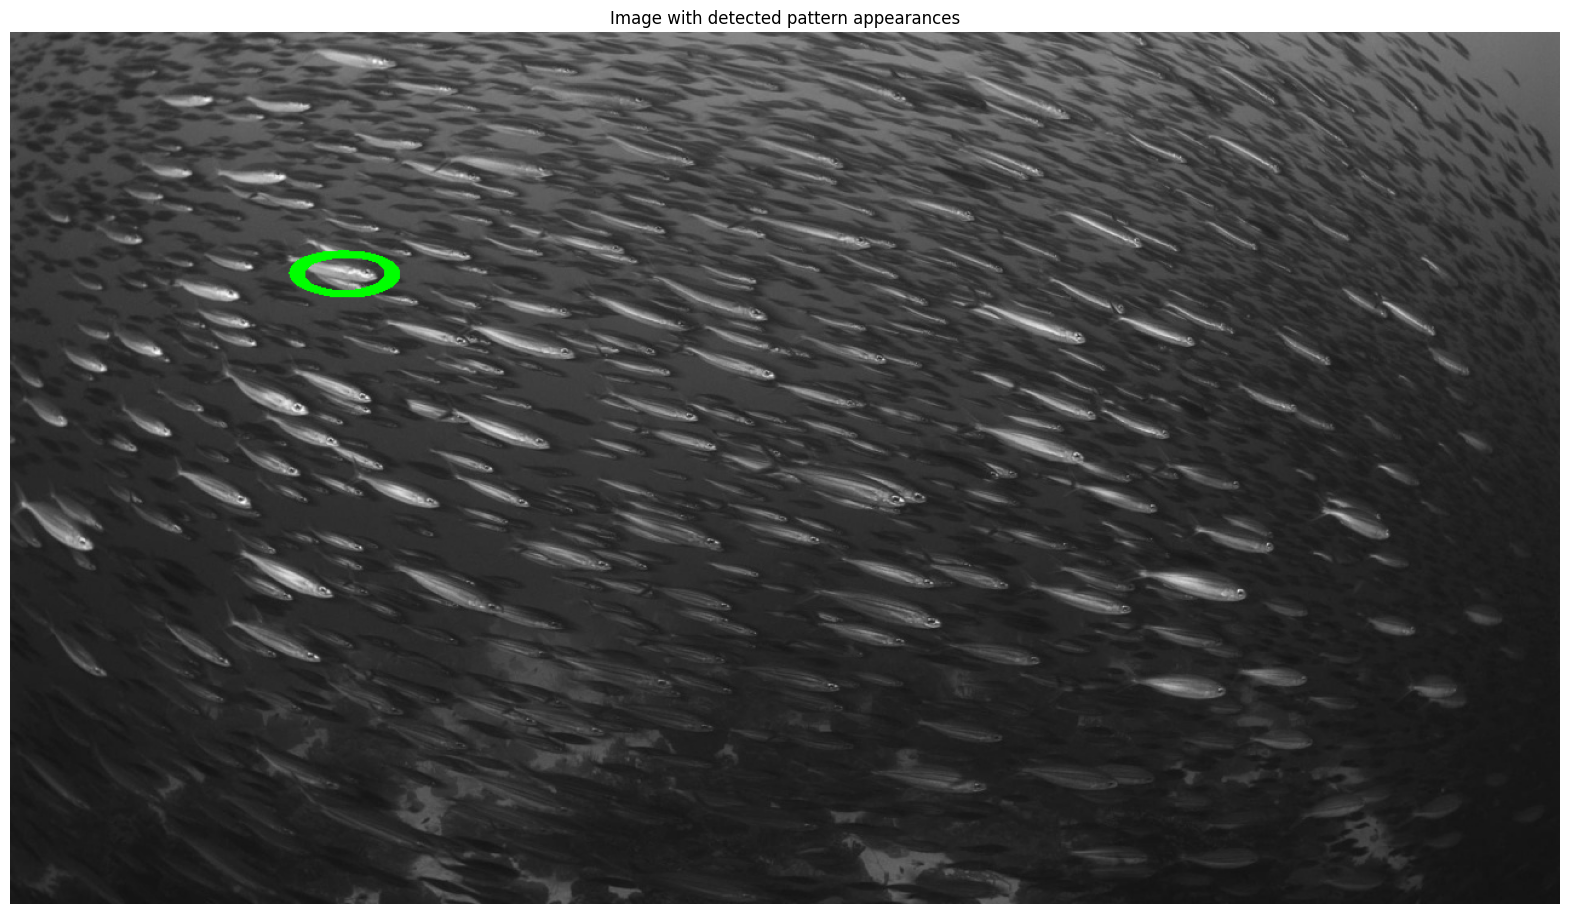

In [28]:

show_pattern(image_to_array(inverted_image), correlation, 0.98, inverted_pattern.shape, thickness = 3)